In [1]:
import os
import re
import wave
import torch
import hashlib
import kagglehub
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

from torch import nn
from PIL import Image
from io import BytesIO
from scipy import signal
# from google.colab import drive
from torchsummary import summary
from IPython.display import Audio
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
from pydub import AudioSegment
from sklearn.model_selection import train_test_split

/home/kuba/.pyenv/versions/asar/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [69]:
import os
import random

def delete_files_with_pattern(directory, pattern, percentage=60):
    # Get a list of files matching the pattern
    files = [f for f in os.listdir(directory) if f.startswith(pattern) and os.path.isfile(os.path.join(directory, f))]
    
    # Shuffle the list to ensure randomness
    random.shuffle(files)
    
    # Calculate the number of files to delete
    num_to_delete = int(len(files) * (percentage / 100))
    
    # Delete the files
    for file in files[:num_to_delete]:
        file_path = os.path.join(directory, file)
        os.remove(file_path)
        print(f"Deleted: {file_path}")

# Example Usage
directory_path = "train_data"
file_pattern = "tree"
delete_files_with_pattern(directory_path, file_pattern)


Deleted: train_data/tree_7943.png
Deleted: train_data/tree_8284.png
Deleted: train_data/tree_7120.png
Deleted: train_data/tree_7137.png
Deleted: train_data/tree_8793.png
Deleted: train_data/tree_7831.png
Deleted: train_data/tree_8577.png
Deleted: train_data/tree_7960.png
Deleted: train_data/tree_8386.png
Deleted: train_data/tree_7842.png
Deleted: train_data/tree_8608.png
Deleted: train_data/tree_8483.png
Deleted: train_data/tree_7696.png
Deleted: train_data/tree_8681.png
Deleted: train_data/tree_8163.png
Deleted: train_data/tree_8531.png
Deleted: train_data/tree_7323.png
Deleted: train_data/tree_8596.png
Deleted: train_data/tree_8368.png
Deleted: train_data/tree_8402.png
Deleted: train_data/tree_8803.png
Deleted: train_data/tree_7752.png
Deleted: train_data/tree_7372.png
Deleted: train_data/tree_8125.png
Deleted: train_data/tree_7562.png
Deleted: train_data/tree_7234.png
Deleted: train_data/tree_7860.png
Deleted: train_data/tree_7792.png
Deleted: train_data/tree_7583.png
Deleted: train

In [46]:
BATCH_SIZE = 16
MAX_FREQ = 4000
CHUNK_SIZE = 16000
SAMPLE_RATE = 16000
MAX_NUM_WAVS_PER_CLASS = 2**27 - 1

In [47]:
path = kagglehub.dataset_download("neehakurelli/google-speech-commands")

print("Path to dataset files:", path, "\n\nFiles:\n")

# !ls /root/.cache/kagglehub/datasets/neehakurelli/google-speech-commands/versions/1

Path to dataset files: /home/kuba/.cache/kagglehub/datasets/neehakurelli/google-speech-commands/versions/1 

Files:



In [48]:
def which_set(filename, validation_percentage, testing_percentage):
  base_name = os.path.basename(filename)
  hash_name = re.sub(r"_nohash_.*$", "", base_name)
  hash_name_hashed = hashlib.sha1(hash_name.encode()).hexdigest()
  percentage_hash = ((int(hash_name_hashed, 16) %
                      (MAX_NUM_WAVS_PER_CLASS + 1)) *
                      (100.0 / MAX_NUM_WAVS_PER_CLASS))

  if percentage_hash < validation_percentage:
    result = "validation"

  elif percentage_hash < (testing_percentage + validation_percentage):
    result = "testing"

  else:
    result = "training"

  return result


def load_data(path, classes, validation_percentage=10, testing_percentage=10):
  data = []

  for label in os.listdir(path):
    label_path = os.path.join(path, label)

    if not label in classes or not os.path.isdir(label_path):
      continue

    for file_name in os.listdir(label_path):
      if file_name.endswith(".wav"):
        file_path = os.path.join(label_path, file_name)
        category = which_set(file_name, validation_percentage, testing_percentage)

        data.append({
            "File_path": file_path,
            "Label": label,
            "Set": category
        })

  return pd.DataFrame(data)


classes = [x for x in os.listdir(path) if (x[0].islower() or x[0] == "_") and not ".txt" in x]
df = load_data(path, classes)
print(df.head())

train_data = df[df["Set"] == "training"][["File_path", "Label"]]
test_data = df[df["Set"] == "testing"][["File_path", "Label"]]
validation_data = df[df["Set"] == "validation"][["File_path", "Label"]]

print("\nTraining samples:", len(train_data))
print("Testing samples:", len(test_data))
print("Validation samples:", len(validation_data))

                                           File_path Label       Set
0  /home/kuba/.cache/kagglehub/datasets/neehakure...  nine  training
1  /home/kuba/.cache/kagglehub/datasets/neehakure...  nine  training
2  /home/kuba/.cache/kagglehub/datasets/neehakure...  nine   testing
3  /home/kuba/.cache/kagglehub/datasets/neehakure...  nine  training
4  /home/kuba/.cache/kagglehub/datasets/neehakure...  nine  training

Training samples: 51094
Testing samples: 6835
Validation samples: 6798


Label: off 




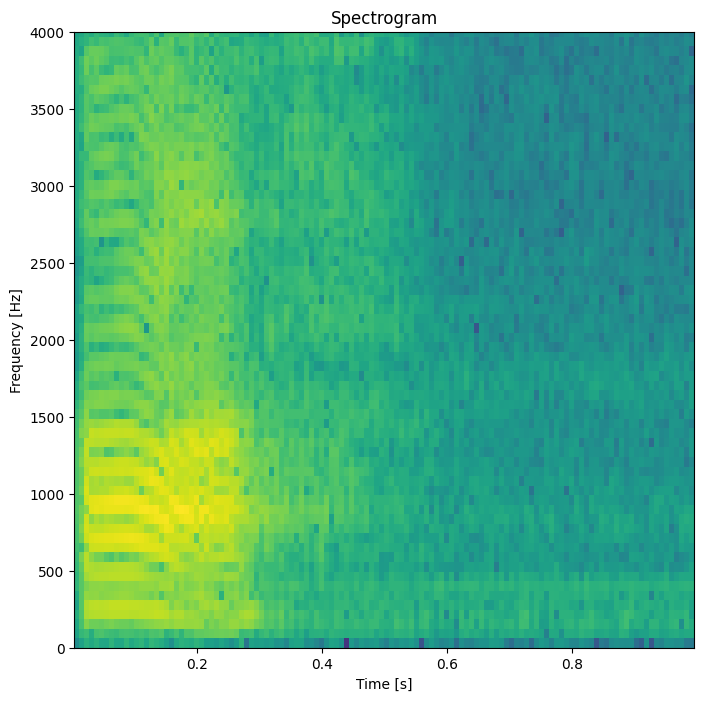

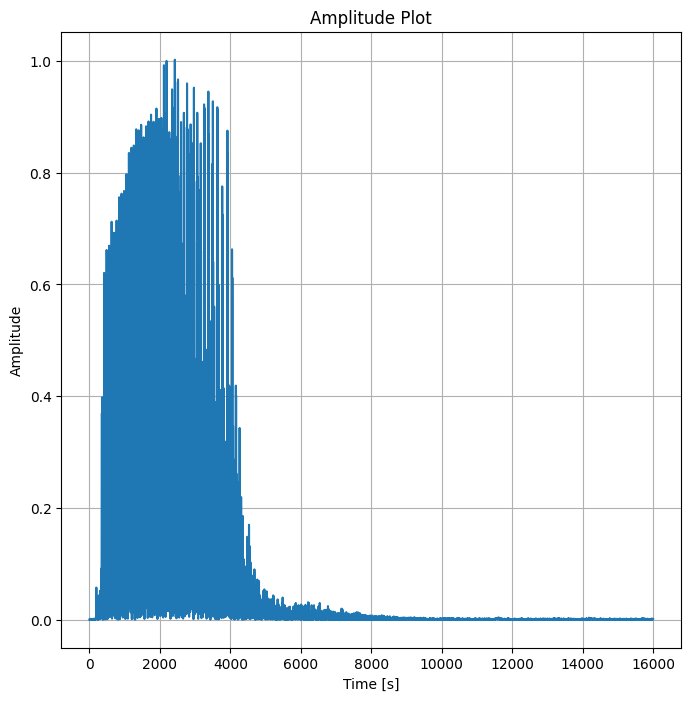

In [70]:
def plot_spectrogram(data):
  fig, ax = plt.subplots(figsize=(8, 8))

  ax.specgram(data, Fs=SAMPLE_RATE)
  ax.set_title("Spectrogram")
  ax.set_xlabel("Time [s]")
  ax.set_ylabel("Frequency [Hz]")
  ax.set_ylim(0, MAX_FREQ)

  plt.show()


def plot_amplitude(data):
  fig, ax = plt.subplots(figsize=(8, 8))

  ax.plot(np.abs(data))
  ax.set_title("Amplitude Plot")
  ax.set_xlabel("Time [s]")
  ax.set_ylabel("Amplitude")
  ax.grid()

  plt.show()


idx = 34000
file_path = train_data.iloc[idx]["File_path"]
label = train_data.iloc[idx]["Label"]
audio = None

with wave.open(file_path, "r") as wav_file:
  audio = wav_file.readframes(CHUNK_SIZE)
  audio = np.frombuffer(audio, dtype=np.int16)
  audio = audio / np.max(np.abs(audio))

print("Label:", label, "\n\n")
plot_spectrogram(audio)
print("\n")
plot_amplitude(audio)
print("\n")
Audio(file_path)

In [71]:


def file_to_spectrogram(file_path, save_path):
  with wave.open(file_path, "rb") as wav_file:
    audio = wav_file.readframes(CHUNK_SIZE)
    audio = np.frombuffer(audio, dtype=np.int16)
    audio = audio / np.max(np.abs(audio))

  fig, ax = plt.subplots(figsize=(1, 1), dpi=64)
  frequencies, times, Sxx = signal.spectrogram(audio, fs=SAMPLE_RATE)
  Sxx = np.clip(Sxx, 1e-10, None)
  ax.pcolormesh(times, frequencies, 10 * np.log10(Sxx, where=Sxx > 0), shading="auto")
  ax.axis("off")

  buf = BytesIO()
  plt.savefig(buf, format="png", bbox_inches="tight", pad_inches=0)
  buf.seek(0)

  img = Image.open(buf)
  print(save_path)
  img.save(save_path)

  plt.close(fig)
  buf.close()


def save_spectrograms(data, save_dir, lbl, other=False):
  save_path = None
  label = None

  for index, row in data.iterrows():
    if row["Label"] == lbl:
      if other:
        label = "other"

      else:
        label = row["Label"]

      file_path = row["File_path"]
      save_path = os.path.join(save_dir, f"{label}_{index}.png")
      file_to_spectrogram(file_path, save_path)


keywords = ["go", "stop", "bed"]

# drive.mount("/content/gdrive")
# dir_path = "/content/gdrive/MyDrive/EASAR/"
# train_path = "/content/gdrive/MyDrive/EASAR/train_data"
# test_path = "/content/gdrive/MyDrive/EASAR/test_data"
# validation_path = "/content/gdrive/MyDrive/EASAR/validation_data"

# dir_path = ""
train_path = "train_data/"
test_path = "test_data/"
validation_path = "validation_data/"


# os.makedirs(dir_path, exist_ok=True)
# os.makedirs(train_path, exist_ok=True)
# os.makedirs(test_path, exist_ok=True)
# os.makedirs(validation_path, exist_ok=True)
# background_dir = "background/"
# for i, file in enumerate(os.listdir(path=background_dir)):
#   file_path = os.path.join(background_dir, file)
#   file_to_spectrogram(file_path=file_path, save_path=os.path.join(train_path, f"background_{i}.png"))
# for x in keywords:
#   idx = classes.index(x)
#   save_spectrograms(train_data, train_path, classes[idx])
#   save_spectrograms(test_data, test_path, classes[idx])
#   save_spectrograms(validation_data, validation_path, classes[idx])

# for i, file in enumerate(os.listdir("silence_chunks/")):
#   save_path = os.path.join(train_path, f"silence_{i}.png")
#   file_to_spectrogram(file_path=f"silence_chunks/{file}", save_path=save_path)

In [72]:
def sample_data(df, labels, n_samples, random_state=0):
    grouped = df[df["Label"].isin(labels)]
    grouped_without_label = grouped.drop(columns=["Label"])

    sampled = grouped_without_label.groupby(grouped["Label"], group_keys=False).apply(
        lambda group: group.sample(n=min(len(group), n_samples), random_state=random_state)
    )

    sampled["Label"] = grouped["Label"].loc[sampled.index]

    return sampled.reset_index(drop=True)


n_files = lambda p: len([f for f in os.listdir(p) if os.path.isfile(os.path.join(p, f))])
other_classes = [cls for cls in classes if cls not in keywords]

n_keywords_train = n_files(train_path) // len(keywords)
n_keywords_test = n_files(test_path) // len(keywords)
n_keywords_validation = n_files(validation_path) // len(keywords)

n_other_train = n_keywords_train // len(other_classes)
# n_other_test = n_keywords_test // len(other_classes)
# n_other_validation = n_keywords_validation // len(other_classes)

# samples_other_train = sample_data(df[df["Set"] == "training"], other_classes, n_other_train)
# samples_other_train = sample_data(df[df["Set"] == "testing"], other_classes, n_other_test)
# samples_other_train = sample_data(df[df["Set"] == "validation"], other_classes, n_other_validation)

# for x in other_classes:
#   save_spectrograms(train_data, train_path, x)
#   save_spectrograms(test_data, test_path, x)
#   save_spectrograms(validation_data, validation_path, x)

In [73]:
print(n_other_train)

85


In [74]:
class PNGDataset(Dataset):
  def __init__(self, root_dir, image_list=None, transform=None):
    self.root_dir = root_dir
    self.transform = transform

    if image_list:
      self.image_list = image_list

    else:
      self.image_list = os.listdir(self.root_dir)


  def __len__(self):
    return len(self.image_list)


  def __getitem__(self, idx):
    img_path = os.path.join(self.root_dir, self.image_list[idx])
    img = Image.open(img_path).convert("RGB")
    lbl = self.image_list[idx][:self.image_list[idx].find("_")]

    if self.transform:
        img = self.transform(img)

    return img, lbl

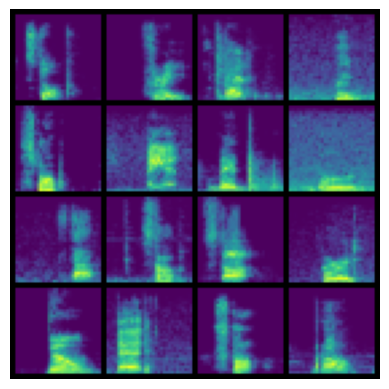

stop three bed bed 
stop bed bed bird 
stop stop stop bird 
down bed stop go 


In [75]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_loader = DataLoader(PNGDataset(train_path, transform=transform),
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          drop_last=True)

test_loader = DataLoader(PNGDataset(test_path, transform=transform),
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         drop_last=True)

validation_loader = DataLoader(PNGDataset(validation_path, transform=transform),
                               batch_size=BATCH_SIZE,
                               shuffle=True,
                               drop_last=True)

n = 4
images, lbls = next(iter(train_loader))
imgs = []
image_grid = make_grid(images[:n ** 2], nrow=n, normalize=True)
plt.imshow(image_grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

for i in range(n):
  for j in range(n):
    print(lbls[n * i + j], end=" ")

  print()

In [91]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), padding=(1, 1))
    self.batch1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.act1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))

    self.conv2 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1))
    self.batch2 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.act2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

    self.conv3 = nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1))
    self.batch3 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.act3 = nn.ReLU()
    self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))

    self.conv4 = nn.Conv2d(256, 512, kernel_size=(3, 3), padding=(1, 1))
    self.batch4 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.act4 = nn.ReLU()
    self.pool4 = nn.MaxPool2d(kernel_size=(2, 2))

    self.flat = nn.Flatten()

    self.fc5 = nn.Linear(2048, 1024)
    self.act5 = nn.ReLU()

    self.fc6 = nn.Linear(1024, 512)
    self.act6 = nn.ReLU()

    self.fc7 = nn.Linear(512, 4)
    self.act7 = nn.Softmax(dim=1)


  def forward(self, x):
    x = self.act1(self.conv1(x))
    x = self.pool1(x)

    x = self.act2(self.conv2(x))
    x = self.pool2(x)

    x = self.act3(self.conv3(x))
    x = self.pool3(x)

    x = self.act4(self.conv4(x))
    x = self.pool4(x)

    x = self.flat(x)

    x = self.act5(self.fc5(x))
    x = self.act6(self.fc6(x))
    x = self.act7(self.fc7(x))

    return x

In [92]:
def weights_init(m):
  classname = m.__class__.__name__

  if isinstance(m, nn.Conv2d):
    nn.init.normal_(m.weight.data, 0.0, 0.02)

  elif isinstance(m, nn.BatchNorm2d):
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [93]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = ConvNet().to(device)
model.apply(weights_init)
v = (3, 32, 32)
summary(model, input_size=v)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
              ReLU-5          [-1, 128, 16, 16]               0
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
              ReLU-8            [-1, 256, 8, 8]               0
         MaxPool2d-9            [-1, 256, 4, 4]               0
           Conv2d-10            [-1, 512, 4, 4]       1,180,160
             ReLU-11            [-1, 512, 4, 4]               0
        MaxPool2d-12            [-1, 512, 2, 2]               0
          Flatten-13                 [-1, 2048]               0
           Linear-14                 [-

Epoch 1: Accuracy: 0.88%
Epoch 1: Precision: 0.9241, Recall: 0.8783, F1 Score: 0.8904
Epoch 2: Accuracy: 0.89%
Epoch 2: Precision: 0.9263, Recall: 0.8931, F1 Score: 0.9018


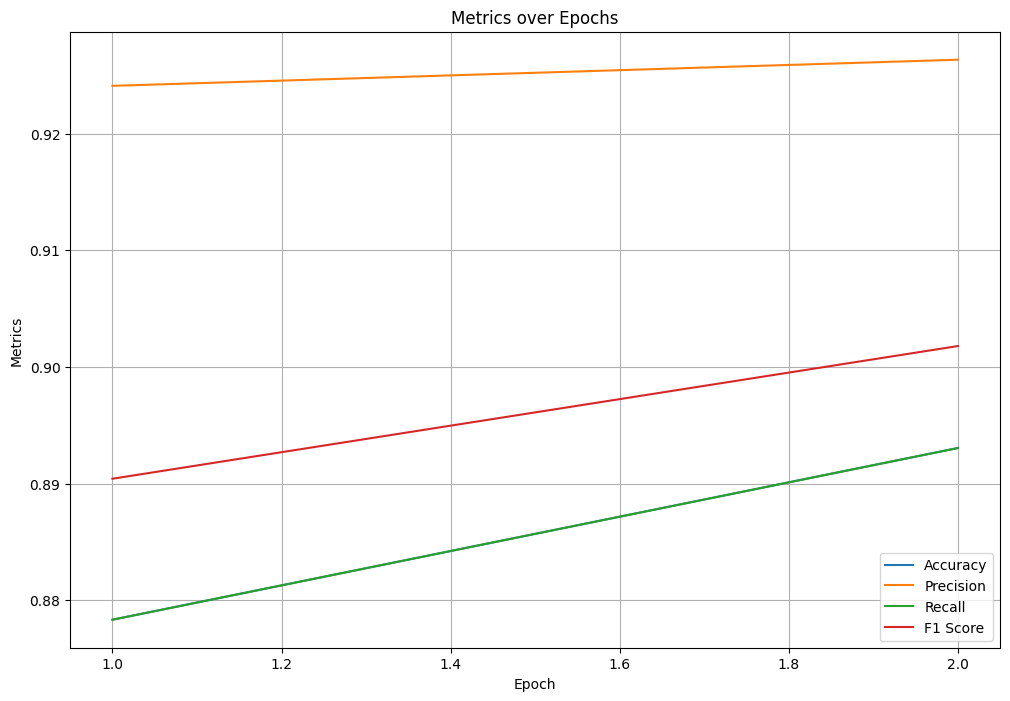

In [ ]:
lbl_map = {"go": 0, "stop": 1, "bed": 2, "other": 3}
epochs = 50

accuracy_per_epoch = []
precision_per_epoch = []
recall_per_epoch = []
f1_per_epoch = []

for epoch in range(epochs):
  for i, (imgs, labels) in enumerate(train_loader):
    labels = torch.tensor(([lbl_map[lbl] if lbl in keywords else lbl_map["other"] for lbl in labels]))
    imgs, labels = imgs.to(device), labels.to(device)
    optimizer.zero_grad()
    output = model(imgs)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

  correct = 0
  total = 0
  all_labels = []
  all_predictions = []

  with torch.no_grad():
    for imgs, labels in test_loader:
      labels = torch.tensor(([lbl_map[lbl] if lbl in keywords else lbl_map["other"] for lbl in labels]))
      
      imgs, labels = imgs.to(device), labels.to(device)
      outs = model(imgs)
      _, predicted = torch.max(outs.data, 1)
      # print(predicted)
      # print(labels)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      all_labels.extend(labels.cpu().numpy())
      all_predictions.extend(predicted.cpu().numpy())

    accuracy = correct / total
    precision = precision_score(all_labels, all_predictions, average="weighted", zero_division=0)
    recall = recall_score(all_labels, all_predictions, average="weighted", zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average="weighted")

    accuracy_per_epoch.append(accuracy)
    precision_per_epoch.append(precision)
    recall_per_epoch.append(recall)
    f1_per_epoch.append(f1)

    print(f"Epoch {epoch + 1}: Accuracy: {accuracy:.2f}%")
    print(f"Epoch {epoch + 1}: Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

plt.figure(figsize=(12, 8))
plt.plot(range(1, epochs + 1), accuracy_per_epoch, label='Accuracy')
plt.plot(range(1, epochs + 1), precision_per_epoch, label='Precision')
plt.plot(range(1, epochs + 1), recall_per_epoch, label='Recall')
plt.plot(range(1, epochs + 1), f1_per_epoch, label='F1 Score')

plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.title('Metrics over Epochs')
plt.legend()
plt.grid()
plt.savefig("Metrics")

In [86]:
torch.save(model.state_dict(), "model")
weights = torch.load("model", weights_only=True)

for name, param in weights.items():
    print(name)

conv1.weight
conv1.bias
batch1.weight
batch1.bias
batch1.running_mean
batch1.running_var
batch1.num_batches_tracked
conv2.weight
conv2.bias
batch2.weight
batch2.bias
batch2.running_mean
batch2.running_var
batch2.num_batches_tracked
conv3.weight
conv3.bias
batch3.weight
batch3.bias
batch3.running_mean
batch3.running_var
batch3.num_batches_tracked
conv4.weight
conv4.bias
batch4.weight
batch4.bias
batch4.running_mean
batch4.running_var
batch4.num_batches_tracked
fc5.weight
fc5.bias
fc6.weight
fc6.bias
fc7.weight
fc7.bias
